In [149]:
# from getopt import getopt
# import cloudpickle
# import pickle
# import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, betabinom
from scipy.stats import linregress
# from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
from time import time, sleep
# from datetime import timedelta

## Simulating scores and p values 

In [150]:
def run_command_gnome(command, title="test", keep_window=False, test=False):
    if keep_window:
        command_suffix = "; $SHELL"
    else:
        command_suffix = ""
        
    if test:
        return f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """
    else:
        os.system(f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """)

In [151]:
# Run simulations
def run_simulations(n_runs=30):
    setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
    process_active = [os.path.isfile(f"data/{sim_name}/process_{i}_running") for i in range(N_PROCESSES)]
    while sum(setting_files)>0:
        for i in range(N_PROCESSES):
            if setting_files[i] and not process_active[i]:
                source = "source ~/anaconda3/etc/profile.d/conda.sh\n"
                conda = "conda activate bayes_topic_measures\n"
                c = f"""python3 perform_sig_test.py --trials_per_sim {trials_per_sim} --process {i} --sim_name {sim_name} --optimal_alloc {optimal_alloc}"""
                run_command_gnome(source+conda+c, title=f"p{i}", keep_window=False)

        sleep(10)
        setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
        process_active = [os.path.isfile(f"data/{sim_name}/process_{i}_running") for i in range(N_PROCESSES)]

In [152]:
# Settings for hoyle's significance testing
hoyle_total_scores = 50*26
hoyle_p_diff = 0.055
hoyle_n_raters = 38
hoyle_scores_per_r = hoyle_total_scores//hoyle_n_raters + 1

In [153]:
# Varying the number of raters
N_PROCESSES = 4
sim_name0 = "5_model_prec"
sim_name1 = "5_model_precOA"

n_sims = 150
trials_per_sim = 1
p_diff = hoyle_p_diff
n_raters = 80
scores_per_r = hoyle_scores_per_r

In [154]:
# Removing all produced files
os.system(f"""rm data/simulations/{sim_name0}.csv""")
os.system(f"""rm data/simulations/{sim_name1}.csv""")
os.system(f"""rm data/{sim_name0}/*""")
os.system(f"""rm -rf data/{sim_name1}""")

# Generate settings file
os.system(f"""
    python3 generate_sim_settings.py --n_raters "{n_raters}" --scores_per_r {scores_per_r} \
    --n_sims {n_sims} --trials_per_sim {trials_per_sim} --sim_name {sim_name0} 
""")

os.system(f"cp -r data/{sim_name0} data/{sim_name1}")
os.system(f"cp data/simulations/{sim_name0}.csv data/simulations/{sim_name1}.csv")


    p_diff=0.055, <class 'float'>
    n_raters=80, <class 'int'>
    scores_per_r=35, <class 'int'>
    total_scores=None, <class 'NoneType'>
    n_sims=150, <class 'int'>
    trials_per_sim=1
    seed=42, <class 'int'>
    sim_name=5_model_prec, <class 'str'>
    chain_method=vectorized, <class 'str'>
    clean_dir=True, <class 'bool'>
    


0

In [155]:
n_runs = 10

sim_name = sim_name0
optimal_alloc = False
run_simulations(n_runs=n_runs)

sim_name = sim_name1
optimal_alloc = True
run_simulations(n_runs=n_runs)

# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to termin

## Adding model precision

In [156]:
scores = pd.DataFrame()
scoresOA = pd.DataFrame()
for sim_id in range(n_sims*4//6):
    a = pd.read_csv(f"data/5_model_prec/score_{sim_id}.csv")
    a.insert(0, "sim_id", sim_id)
    scores = pd.concat([scores, a])
    
    b = pd.read_csv(f"data/5_model_precOA/score_{sim_id}.csv")
    b.insert(0, "sim_id", sim_id)
    scoresOA = pd.concat([scoresOA, b])

In [157]:
# Aggregating cordel model precision from scores
sums = (scores.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
counts = (scores.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
model_prec = pd.merge(sums, counts, on=["sim_id","sim_cordel_id","sim_topic_id"])
model_prec["model_precision"] = model_prec["sum"]/model_prec["count"]
model_prec = model_prec.groupby(["sim_id","sim_cordel_id"]).agg({"model_precision":"mean"}).reset_index()

cordel_0 = (model_prec[model_prec["sim_cordel_id"]==0][["sim_id", "model_precision"]]
            .rename(columns={"model_precision":"cordel_0_prec"}))
cordel_1 = (model_prec[model_prec["sim_cordel_id"]==1][["sim_id", "model_precision"]]
            .rename(columns={"model_precision":"cordel_1_prec"}))
model_prec = pd.merge(cordel_0, cordel_1, on="sim_id")
model_prec["model_prec_diff"] = model_prec["cordel_1_prec"] - model_prec["cordel_0_prec"]

In [159]:
# Aggregating cordel model precision from scores
sums = (scoresOA.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
counts = (scoresOA.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
model_precOA = pd.merge(sums, counts, on=["sim_id","sim_cordel_id","sim_topic_id"])
model_precOA["model_precision"] = model_precOA["sum"]/model_precOA["count"]
model_precOA = model_precOA.groupby(["sim_id","sim_cordel_id"]).agg({"model_precision":"mean"}).reset_index()

cordel_0 = (model_precOA[model_precOA["sim_cordel_id"]==0][["sim_id", "model_precision"]]
            .rename(columns={"model_precision":"cordel_0_prec"}))
cordel_1 = (model_precOA[model_precOA["sim_cordel_id"]==1][["sim_id", "model_precision"]]
            .rename(columns={"model_precision":"cordel_1_prec"}))
model_precOA = pd.merge(cordel_0, cordel_1, on="sim_id")
model_precOA["model_prec_diff"] = model_precOA["cordel_1_prec"] - model_precOA["cordel_0_prec"]

In [163]:
sims = pd.read_csv("data/simulations/5_model_prec.csv")
sims = pd.merge(sims, model_prec, on="sim_id")
simsOA = pd.read_csv("data/simulations/5_model_precOA.csv")
simsOA = pd.merge(simsOA, model_precOA, on="sim_id")

## Plotting Results

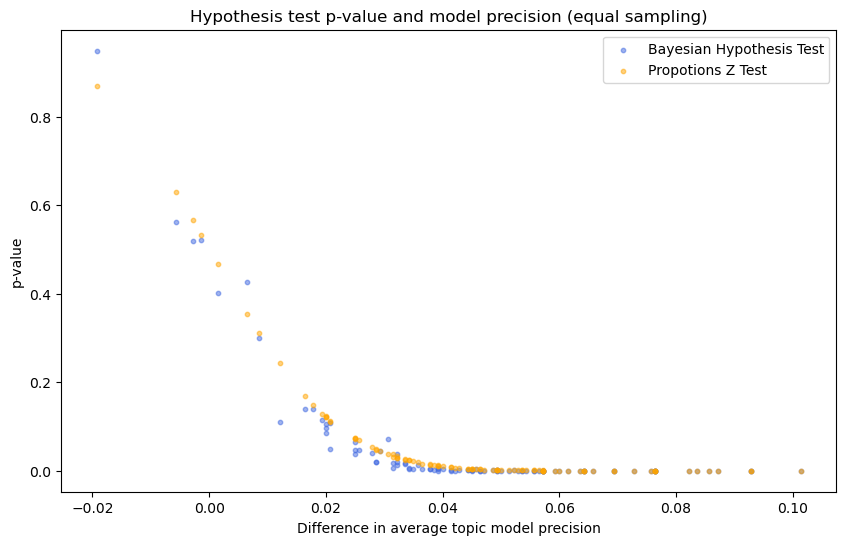

In [172]:
sim_results = sims
legend = {"orange":"Propotions Z Test", "royalblue":"Bayesian Hypothesis Test"}
test = {"orange":"propz", "royalblue":"bht"}

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for colour in reversed(legend):
    ax.scatter(sim_results["model_prec_diff"], sim_results[f"{test[colour]}_pval"],
               c=colour, label=legend[colour], s=10, alpha=0.5)
ax.set_title("Hypothesis test p-value and model precision (equal sampling)")
# ax.set_yscale("symlog", linthresh=1e-2)
ax.set_xlabel("Difference in average topic model precision")
ax.set_ylabel("p-value")
ax.legend()
plt.show()

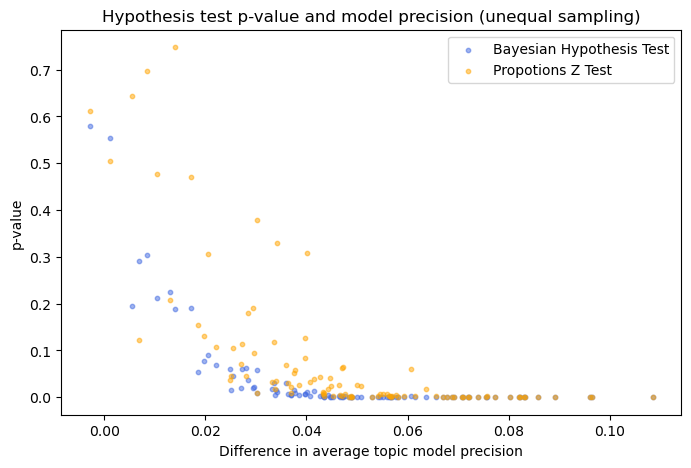

In [173]:
sim_results = simsOA
legend = {"orange":"Propotions Z Test", "royalblue":"Bayesian Hypothesis Test"}
test = {"orange":"propz", "royalblue":"bht"}

fig, ax = plt.subplots(1, 1, figsize=(8,5))
for colour in reversed(legend):
    ax.scatter(sim_results["model_prec_diff"], sim_results[f"{test[colour]}_pval"],
               c=colour, label=legend[colour], s=10, alpha=0.5)
ax.set_title("Hypothesis test p-value and model precision (unequal sampling)")
# ax.set_yscale("symlog", linthresh=1e-2)
ax.set_xlabel("Difference in average topic model precision")
ax.set_ylabel("p-value")
ax.legend()
plt.show()